# FitMultiCell tutorial for parameter recovery studies and model selection

<div style="text-align: justify"> 
The tutorial starts by estimating the posterior distributions of two parameters for a cell motility model defined in Morpheus and found in the 'Demo_CellMotility.xml' file. The fit is done using experimental data and the mean Square Dsiaplcement (MSD) and Direction Autocorrelation (DAC) functions as distance functions for the approximate Bayesian computation algorithm. 
</div>

## Imports:

In [72]:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import tidynamics                     # to get sliding history stats in N*logN instead of N^2
from pyabc import SingleCoreSampler

from pyabc.weighted_statistics import *
from pyabc.visualization.kde import *

## Parameter recovery from experimental data
### Defining model file and location of parameters within the xml

In [168]:
file_ = "Demo_CellMotility.xml"
par_map = {'motion_strength': './Global/Constant[@symbol="motion_strength"]',
           'noise_level': './Global/Constant[@symbol="noise_level"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

MorpheusModel {
	name      : Demo_CellMotility.xml
}


In [169]:
true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

# experimentally measured data:
measured_data = {'IdSumstat__time': np.array([0, 100, 200, 300, 400]),\
                 'IdSumstat__MSD': np.array([0, 1640, 5330, 10400, 15800]),\
                 'IdSumstat__DAC': np.array([1, 0.49, 0.19, 0.07, 0.07])}

### Setting prior distribution and distance functions

In [15]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

# manually defined summary statistics

def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][1:],val1['IdSumstat__cell.center.y'][1:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][1:]/val1['IdSumstat__velocity.abs'][1:],val1['IdSumstat__velocity.y'][1:]/val1['IdSumstat__velocity.abs'][1:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

### Instantiate ABCSMC module

In [17]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)#20
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=3, start_time=2021-02-23 08:47:27.444920, end_time=None)>


In [18]:
abc.run(max_nr_populations=8)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 27983.573832371745
INFO:ABC:t: 0, eps: 27983.573832371745.
INFO:ABC:Acceptance rate: 20 / 45 = 4.4444e-01, ESS=2.0000e+01.
INFO:ABC:t: 1, eps: 20009.006704658877.
INFO:ABC:Acceptance rate: 20 / 74 = 2.7027e-01, ESS=1.7245e+01.
INFO:ABC:t: 2, eps: 12794.060730497542.
INFO:ABC:Acceptance rate: 20 / 53 = 3.7736e-01, ESS=1.7593e+01.
INFO:ABC:t: 3, eps: 8581.318302927662.
INFO:ABC:Acceptance rate: 20 / 90 = 2.2222e-01, ESS=1.9642e+01.
INFO:ABC:t: 4, eps: 6191.674277440488.
INFO:ABC:Acceptance rate: 20 / 158 = 1.2658e-01, ESS=1.5221e+01.
INFO:ABC:t: 5, eps: 4800.650472429225.
INFO:ABC:Acceptance rate: 20 / 271 = 7.3801e-02, ESS=1.5417e+01.
INFO:ABC:t: 6, eps: 3941.792147380547.
INFO:ABC:Acceptance rate: 20 / 327 = 6.1162e-02, ESS=1.1782e+01.
INFO:ABC:t: 7, eps: 3057.663900192228.
INFO:ABC:Acceptance rate: 20 / 1050 = 1.9048e-02, ESS=1.0538e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <A

/Users/sebas/opt/anaconda3/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


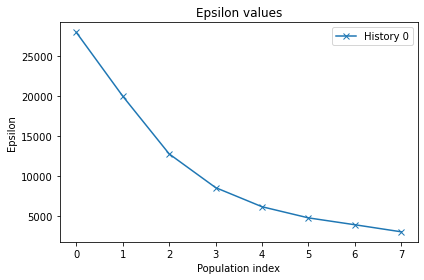

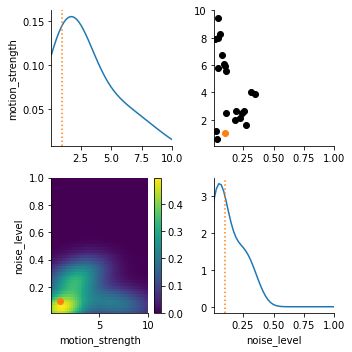

In [73]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

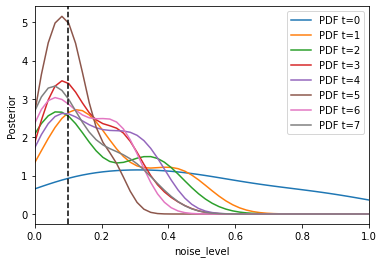

In [91]:
fig, ax = plt.subplots()
for t in range(h.max_t+1):
    df, w = h.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=1,
        x="noise_level", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(true_pars['noise_level'], color="k", linestyle="dashed");
ax.legend();

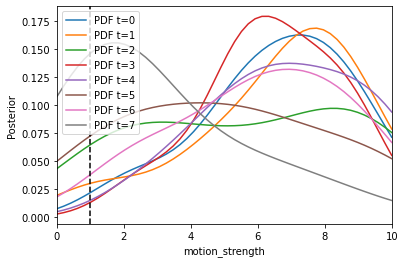

In [93]:
fig, ax = plt.subplots()
for t in range(h.max_t+1):
    df, w = h.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=10,
        x="motion_strength", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(true_pars['motion_strength'], color="k", linestyle="dashed");
ax.legend();

In [74]:
ms = weighted_median(df['motion_strength'].to_numpy(), w)
nl = weighted_median(df['noise_level'].to_numpy(), w)
print(ms, nl)

2.2745638213732815 0.08007794044897883


mean MSD =  [-1.07684173e-11  2.02253258e+03  6.26461150e+03  1.06391665e+04
  1.43395903e+04]
sem MSD =  [8.48170709e-12 6.04298541e+01 2.34663765e+02 5.33697344e+02
 8.36820909e+02]
mean DAC =  [ 0.26651689  0.12293874  0.02127944 -0.04417787 -0.08105276]
sem DAC =  [0.00773739 0.00759784 0.00989273 0.01313715 0.01766242]


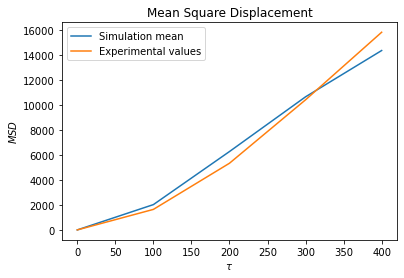

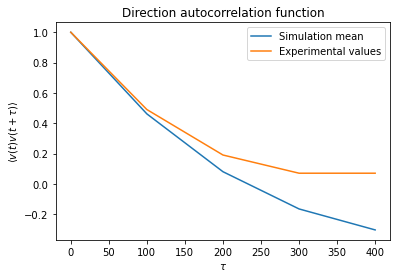

In [171]:
# summary statistics for N repetitions of the model simulation and plotting

fit_pars = {'motion_strength': 2.27, 'noise_level': 0.08}
N = 100 # runs to average over, make sure random_seed is off in Morpheus
time = np.arange(5)
meantival1 = np.zeros(5)
meantival2 = np.zeros(5)
semtival1 = np.zeros(5)
semtival2 = np.zeros(5)
count = 0

for i in range(N):
    simulated_data = model.sample(fit_pars)
    val1vec = np.column_stack([simulated_data['IdSumstat__cell.center.x'][1:],simulated_data['IdSumstat__cell.center.y'][1:]])
    meantival1 += tidynamics.msd(val1vec)
    semtival1 += (tidynamics.msd(val1vec))**2
    #val2vec = np.column_stack([simulated_data['IdSumstat__velocity.x'][1:]/simulated_data['IdSumstat__velocity.abs'][1:],simulated_data['IdSumstat__velocity.y'][1:]/simulated_data['IdSumstat__velocity.abs'][1:]])
    val2vec = np.column_stack([simulated_data['IdSumstat__velocity.x'][1:],simulated_data['IdSumstat__velocity.y'][1:]])
    meantival2 += tidynamics.acf(val2vec)    
    semtival2 += (tidynamics.acf(val2vec))**2
    count += 1

meantival1 /= count
semtival1 = np.sqrt(((semtival1 / count) - (meantival1)**2) / count)
meantival2 /= count
semtival2 = np.sqrt(((semtival2 / count) - (meantival2)**2) / count)

print('mean MSD = ',meantival1)
print( 'sem MSD = ',semtival1)
print('mean DAC = ',meantival2)
print( 'sem DAC = ',semtival2)

# plot MSD
plt.plot(measured_data['IdSumstat__time'], meantival1, label='Simulation mean')
plt.plot(measured_data['IdSumstat__time'], measured_data['IdSumstat__MSD'], label='Experimental values')
plt.legend()
plt.title('Mean Square Displacement')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$MSD$')
plt.show()

# plot DAC
plt.plot(measured_data['IdSumstat__time'], meantival2/meantival2[0], label='Simulation mean')
plt.plot(measured_data['IdSumstat__time'], measured_data['IdSumstat__DAC'], label='Experimental values')
plt.legend()
plt.title('Direction autocorrelation function')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\langle v(t) v(t+\tau) \rangle$')
plt.show()

### Additional plots:

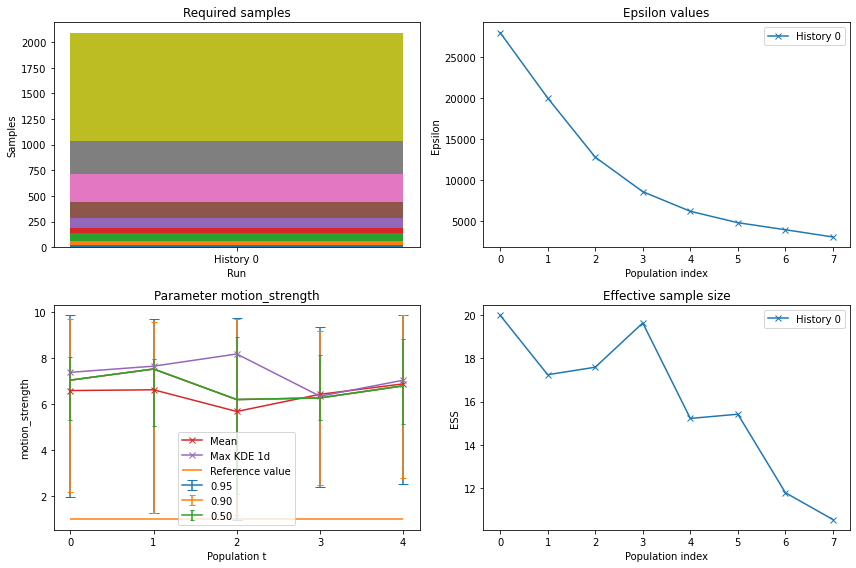

In [83]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(h, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(h, ax=arr_ax[0][1])
pyabc.visualization.plot_credible_intervals(
    h, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
    show_mean=True, show_kde_max_1d=True,
    refval=true_pars, arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(h, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

## Model selection for chemotactic-sensitive cell polarization

<div style="text-align: justify"> 
This section shows a general pipeline for doing Bayesian model selection using the previously introduced tools and a new model of cell motility based on spatio-temporal polarization of a cell under a chemical gradient. In this model, the cell motion is driven in the same direction as a polarity vector. The polarity vector's axis points from the region in the cell membrane where the activator concentration value has a minimum towards the region where the maximum value can be found. This spatio-temporal mechanism was proposed in <a href="https://jcs.biologists.org/content/112/17/2867.short"> Meinhardt 1999</a>. The model is defined in Morpheus and has the name 'CellPolarity.xml'. For ilustration purposes, a false model is created where the decaying term of the activator is omitted. The false model ca be found on the 'CellPolarity_False1.xml' file. 
</div>

In [94]:
file_ = "CellPolarity.xml"
par_map = {'r_a': "./CellTypes/CellType[@name='Cell']/System/Constant[@symbol='r_a']",# Decay rate of activator
           'r_i1': "./CellTypes/CellType[@name='Cell']/System/Constant[@symbol='r_i1']"}# Decay rate of inhibitor 1

model_True = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model_True)

MorpheusModel {
	name      : CellPolarity.xml
}


In [160]:
# Create parameter mapping
par_map = {
    "r_a": "./CellTypes/CellType[@name='Cell']/System/Constant[@symbol='r_a']",# Decay rate of activator
    "strength": "./CellTypes/CellType[@name='Cell']/DirectedMotion[@strength]"# Strength in motion
}

# Create model instance
model_true = fmc.model.MorpheusModel(
    "CellPolarity.xml",
    par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",#"/usr/local/bin/morpheus",
    show_stdout=False,
    show_stderr=True,
    raise_on_error=False
)

### Define and produce 'observed data'

In [161]:
"""
Sanity check: it is always a good idea to verify 
that the model is working before attempting to 
instantiate the ABCSMC method
"""
model_true.sample(true_pars)

{'loc': '/var/folders/2p/1dvbzms96qb53h91c3fckhg40000gn/T/morpheus_model_i5ptbk8l',
 'IdSumstat__t': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150]),
 'IdSumstat__cell.id': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'IdSumstat__cell.center.x': array([25.        , 24.625     , 23.76642336, 23.59482759, 25.32745098,
        30.27911647, 34.0254902 , 38.02755906, 41.82868526, 45.625     ,
        49.86973948, 54.0256917 , 58.14117647, 62.6888454 , 67.37065637,
        72.188     ]),
 'IdSumstat__cell.center.y': array([120.       , 119.6666667, 120.0364964, 119.7528736, 120.7607843,
        122.186747 , 123.8333333, 126.3346457, 129.2250996, 131.906746 ,
        133.3787575, 134.7193676, 135.4784314, 136.1682975, 136.1351351,
        136.168    ]),
 'IdSumstat__mean_c_a': array([0.5       , 0.44539349, 0.39503886, 0.35014239, 0.31088789,
        0.27892663, 0.25349059, 0.23290675, 0.21629337, 0.20279735,
        0.1915803 , 0.1

In [126]:
"""
Specify the ground-truth values of the parameters:
"""
true_pars = {
    "r_a": 0.02,
    "strength": 0.5
}
# Bounds for true parameters
true_pars_limits = {
    "r_a": (0.5 * 0.02, 2.0 * 0.02),
    "strength": (0.5 * 0.5, 2.0 * 0.5)
}

"""
Define auxiliary functions for summary statistics:
"""
# Radius of gyration:
def distRG(R_data, time_interval=1):
    """
    Calculates the radius of gyration for R_data corresponding to a single trajectory over time.
    # Data structure:
    -> R_data: N_steps x 2
    """
    N_total = len(R_data)
    Rg = np.zeros(N_total)
    for i in range(N_total-1):
        R_cm = sum(R_data[:i+2]) / (i+2)
        #print(R_cm)
        Rg[i+1] = (sum((R_data[:i+2] - R_cm)**2)).sum() / ((i+1)*time_interval)
    Rg[0] = 0
    return np.sqrt(Rg)

"""
Obtain 'ground-truth data' for 100 simulations
"""
# Simulating data on average:
N = 100
tot_time = 15
t_init = 1
arrayVAC = np.zeros((N, tot_time))
arrayRG = np.zeros((N, tot_time))

for i in range(N):
    simulated_data = model.sample(true_pars)
    val1vec = np.column_stack([simulated_data['IdSumstat__cell.center.x'][t_init:],simulated_data['IdSumstat__cell.center.y'][t_init:]])
    arrayVAC[i] = tidynamics.acf(np.column_stack([simulated_data['IdSumstat__velocity.x'][t_init:],simulated_data['IdSumstat__velocity.y'][t_init:]]))
    arrayRG[i] = distRG(val1vec)

### Define average of measured data dictionary:

In [127]:
VAC = np.array([arrayVAC[:,i].mean() for i in range(15)])
RG = np.array([arrayRG[:,i].mean() for i in range(15)])
measured_data = {'IdSumstat__time': np.arange(0, 15, 1),\
                 'IdSumstat__VAC':VAC,\
                 'IdSumstat__RG': RG}

### Definition of second (false) model

In [166]:
# Changing last term in activator equation (squaring)
model_false = fmc.model.MorpheusModel(
    "CellPolarity_False1.xml",
    par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",#"/usr/local/bin/morpheus",
    show_stdout=False,
    show_stderr=True,
    raise_on_error=False
)

### Define models and priors for ABCSMC instance

In [165]:
# Specify models and priors
models = [model, model_false]

priors = [pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_pars_limits.items()}
),pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_pars_limits.items()}
)]

# Different summary statistics functions:
# Radius of Gyration:
def distanceRG(val1, val2):
    R = distRG(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]]))
    d = np.sqrt(np.sum((R - val2['IdSumstat__RG'])**2))
    return d

# Direction autocorrelation function:
def distanceVAC(val1, val2):
    diff = tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][t_init:],val1['IdSumstat__velocity.y'][t_init:]])) - val2['IdSumstat__VAC']
    d = np.sqrt(np.sum(diff**2))
    return d

distance = pyabc.AdaptiveAggregatedDistance([distanceRG, distanceVAC], adaptive=False)

In [155]:
# We plug all the ABC options together
abc = pyabc.ABCSMC(
    models, priors,
    distance)

INFO:Sampler:Parallelizing the sampling on 4 cores.


In [156]:
db_path = ("sqlite:///model_comparison")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=3, start_time=2021-02-24 18:36:13.321934, end_time=None)>


In [157]:
history = abc.run(max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.8018894217825814
INFO:ABC:t: 0, eps: 0.8018894217825814.
INFO:ABC:Acceptance rate: 100 / 174 = 5.7471e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5990130490514672.
INFO:ABC:Acceptance rate: 100 / 391 = 2.5575e-01, ESS=8.5797e+01.
INFO:ABC:t: 2, eps: 0.5153835550236128.
INFO:ABC:Acceptance rate: 100 / 587 = 1.7036e-01, ESS=9.3899e+01.
INFO:ABC:t: 3, eps: 0.4551402987160421.
INFO:ABC:Acceptance rate: 100 / 969 = 1.0320e-01, ESS=7.9711e+01.
INFO:ABC:t: 4, eps: 0.4028924663614979.
INFO:ABC:Acceptance rate: 100 / 1186 = 8.4317e-02, ESS=3.0717e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=3, start_time=2021-02-24 18:36:13.321934, end_time=2021-02-24 18:41:31.232802)>


In [158]:
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.600000,0.400000
1,0.498775,0.501225
2,0.545757,0.454243
3,0.546842,0.453158
4,0.550878,0.449122


<AxesSubplot:title={'center':'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

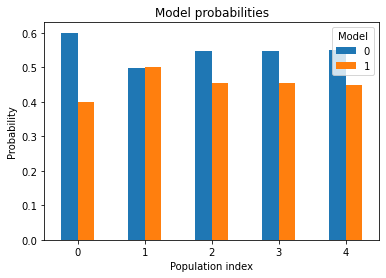

In [159]:
pyabc.visualization.plot_model_probabilities(history)
